In [98]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [99]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script> so much code! click <a href="javascript:code_toggle()">here</a>.''')

In [100]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp
import pandas as pd
import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc
import pickle
import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy

#from matplotlib import reload
import arrow
import gsw
import time

%matplotlib inline

plt.rcParams.update({'font.size': 20,
                     'xtick.labelsize' : 20,
                     'ytick.labelsize' : 20})

available data columns
['year', 'SSP1-1.9_NH', 'SSP1-2.6_NH', 'SSP2-4.5', 'SSP3-7.0', 'SSP5-8.5']


Text(0, 0.5, 'CO2 ppm')

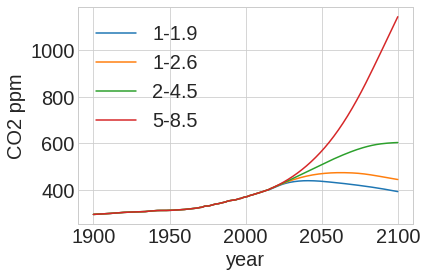

In [101]:
df = pd.read_csv('./meinshausen/meinshausen_scenario_conc.csv')
data_top = list(df.columns) 
print('available data columns')
print(data_top)

year = np.array(df['year'][:])
SSP1_1pt9_NH = np.array(df['SSP1-1.9_NH'][:])
SSP1_2pt6_NH = np.array(df['SSP1-2.6_NH'][:])
SSP2_4pt5_NH = np.array(df['SSP2-4.5'][:])
SSP2_4pt5_NH = np.array(df['SSP2-4.5'][:])
SSP5_8pt5_NH = np.array(df['SSP5-8.5'][:])

plt.plot(year,SSP1_1pt9_NH, label = '1-1.9')
plt.plot(year,SSP1_2pt6_NH, label = '1-2.6')
plt.plot(year,SSP2_4pt5_NH, label = '2-4.5')
plt.plot(year,SSP5_8pt5_NH, label = '5-8.5')
plt.legend()
plt.xlabel('year')
plt.ylabel('CO2 ppm')    

In [102]:


def co2_from_year(scen,tyear):
    
    # building for 2_4pt5
    if (scen == '2_4pt5'): 

        t_co2 = SSP2_4pt5_NH[year == tyear]
                             
    if scen == '5_8pt5':
        
        t_co2 = SSP5_8pt5_NH[year == tyear]
        
    return t_co2[0]
                             
w = co2_from_year('2_4pt5',2051)


In [103]:
SSP2_4pt5_NH[0]

295.8

In [104]:
dics = '/ocean/tjarniko/MEOPAR/analysis_tereza/notebooks/PI_CARBON_PAPER'
dics2  = '/PI_BOUND_COND/CLEAN/preind_DIC/'

fil = 'LO_AOUmethod_stoicCO_diseq_allup_y2015m01d20_preind_DIC.nc'


w = nc.Dataset(f'{dics}{dics2}{fil}')
print(w['preindustrial_DIC'])

sigma0 = w['preindustrial_DIC']['sigma0'][:]
print(np.shape(sigma0))
# params0 = 0.1301889490932413
# params1 = 3.8509914822057825
# params2 = 8.301166081413104 #change to 2015 since model year is 2015
# age = (params0 *np.exp(-params1*(25.15-sigma0))+params2)


<class 'netCDF4._netCDF4.Group'>
group /preindustrial_DIC:
    dimensions(sizes): xval(950), depth(40)
    variables(dimensions): float32 sigma0(depth,xval), float32 pycnal_last_at_surface(depth,xval), float32 pycnal_witnessed_atm_co2(depth,xval), float32 AOU(depth,xval), float32 preformed_pco2(depth,xval), float32 deltaDIC(depth,xval), float32 preind_dic(depth,xval)
    groups: 

(40, 950)


In [105]:
def co2_from_year(scen,tyear):
    
    # building for 2_4pt5
    if (scen == '2_4pt5'): 

        t_co2 = SSP2_4pt5_NH[year == tyear]
                             
    if scen == '5_8pt5':
        
        t_co2 = SSP5_8pt5_NH[year == tyear]
        
    return t_co2
                            

def find_DIC_corresp_to_pco2(tsal, ttemp, tpco2, tta, pres_atm, depth_this):
    
    import numpy as np
    import mocsy
    
    steps = 10000
    tsal_r = np.zeros([steps])
    tsal_r[:] = tsal
    ttemp_r = np.zeros([steps])
    ttemp_r[:] = ttemp
    tta_r = np.zeros([steps])
    tta_r[:] = tta * 1e-3
    tpres_r = np.zeros([steps])
    tpres_r[:] = pres_atm
    depth_r = np.zeros([steps])
    depth_r[:] = depth_this
    tzero = np.zeros([steps])

    end_d = 2400
    start_d = 600
    intvl = (end_d - start_d)/steps
    tdic_r = np.arange(start_d,end_d-0.1,intvl) * 1e-3
    
    response_tup = mocsy.mvars(temp=ttemp_r, sal=tsal_r, alk=tta_r, dic=tdic_r, 
                       sil=tzero, phos=tzero, patm=tpres_r, depth=depth_r, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup    
    
    diffmat = pco2 - tpco2
    idx, ans = find_nearest( diffmat,0 )
    
    if ans> 2:
        print('Danger, pco2 found >2 uatm from pco2 given')
#     print(idx)
#     print('difference between real pco2 and pco2 from calc. dic: ',ans)
#     print('DIC found this way:', tdic_r[idx]*1e3)
    fin_dic = tdic_r[idx]*1e3
    
    return fin_dic

def oned_moxy(tsal, ttemp, tdic, tta, pres_atm, depth_this):
    import sys
    sys.path.append('/data/tjarniko/mocsy')
    import mocsy
    import numpy as np
    import gsw
    
    tsra = np.ravel(tsal)
    ttera = np.ravel(ttemp)
    ttara = np.ravel(tta) * 1e-3
    tdra = np.ravel(tdic) * 1e-3
    tzero = np.zeros_like(tsra)
    tpressure = np.zeros_like(tsra)
    #tdepth = np.zeros_like(tsra)
    tpressure[:] = pres_atm
    tdepth = np.ravel(depth_this)
    tzero = tpressure * 0 
    
    #no need to convert these, they're already converted
    #tsra_psu = tsra*35/35.16504
    #ttera_is = gsw.t_from_CT(tsra,ttera,tzero)

    response_tup = mocsy.mvars(temp=ttera, sal=tsra, alk=ttara, dic=tdra, 
                       sil=tzero, phos=tzero, patm=tpressure, depth=tdepth, lat=tzero, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
    pH,pco2,fco2,co2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup
    
    return pH, OmegaA, pco2

def find_nearest(array, value):
    
    import numpy as np
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]


def future_co2_fc(scen,obs_year,target_year,water_age,AOU,DIC,TA,S,T,p, verbose = True):
    """
    Usage: adaptation of c* gruber method 
    Inputs:
        current_year 
        age_of_waterage of the water parcel - how old is the water
        DIC  : umol/L
        TA   : umol/L
        AOU  : umol/L
        S    :  g/kg
        T    :  cons. temp
        p    :  meters/dbar
        
    """

    year_watermass_at_surface = int(obs_year - water_age)
    watermass_witnessed_co2_obs = int(co2_from_year(scen,year_watermass_at_surface))
    print(watermass_witnessed_co2_obs)
    watermass_witnessed_co2_target = int(co2_from_year(scen,year_watermass_at_surface+(target_year-obs_year)))
    #convert AOU to AOU_stoich, ratio of 
    AOU_stoich = AOU * (117/170)
    
    #step A
    preformed_DIC = DIC - AOU_stoich
        
    if verbose == True:

        print('DIC of observation: '+str(DIC) + ' umol/kg')
        print('AOU: '+str(AOU) + ' umol/kg')
        print('stoich AOU (mult. by C:O ratio 117/170): '+str(AOU_stoich) + ' umol/kg')    
        print('preformed_DIC (DIC when last surface, so DIC less stoich AOU) '+str(preformed_DIC))
        #print('year to calculate co2 for: '+str(current_year))
        print('watermass age: ' + str(water_age))
        print('year observation was made: '+str(obs_year))
        print('year we are trying to calculate DIC for: '+str(target_year))
    #get preformed pCO2
    #step B - calculate pref_pco2_when_last_at_surface
    pHr, OmAr, pco2r = oned_moxy(S, T, preformed_DIC, TA, 1, 0)
    obsyear_pref_pco2 = pco2r
    diseqPCO2 = obsyear_pref_pco2 - watermass_witnessed_co2_obs
    targetyear_pref_pco2 = watermass_witnessed_co2_target + diseqPCO2
    
    preind_pref_pco2 = 284 + diseqPCO2
    

    if verbose == True:
        print('watermass last at surface: '+str(year_watermass_at_surface))
        print('watermass witnessed atm co2: ' + str(watermass_witnessed_co2_obs))
        print('preformed_pco2): '+str(pco2r))
        print('diseq co2: '+str(diseqPCO2))
        print('preindustrial preformed pco2 (284+diseq): '+str(preind_pref_pco2))

    #step C: get preindustrial preformed DIC and preindustrial dic
    preind_pref_DIC = find_DIC_corresp_to_pco2(S, T, preind_pref_pco2, TA, 1, 0)
    obsyear_pref_DIC = find_DIC_corresp_to_pco2(S, T, obsyear_pref_pco2, TA, 1, 0)
    targetyear_pref_DIC = find_DIC_corresp_to_pco2(S, T, targetyear_pref_pco2, TA, 1, 0)
    
    preind_DIC = preind_pref_DIC + AOU_stoich
    obsyear_DIC = obsyear_pref_DIC + AOU_stoich
    targetyear_DIC = targetyear_pref_DIC + AOU_stoich
    if verbose == True:
        print('preindustrial preformed DIC: '+str(preind_pref_DIC))
        print('preindustrial DIC: '+str(preind_DIC))
        print('obsyear preformed DIC: '+str(obsyear_pref_DIC))
        print('obsyear DIC: '+str(obsyear_DIC))    
        print('targetyear preformed DIC: '+str(targetyear_pref_DIC))
        print('targetyear DIC: '+str(targetyear_DIC))    

    return targetyear_DIC



In [106]:
obs_year = 2010
target_year = 2040
water_age = 10
AOU = 50
DIC = 2100
TA = 2200
S = 28
T = 15
p = 30
scen = '5_8pt5'
w = future_co2_fc(scen,obs_year,target_year,water_age,AOU,DIC,TA,S,T,p, verbose = True)

370
DIC of observation: 2100 umol/kg
AOU: 50 umol/kg
stoich AOU (mult. by C:O ratio 117/170): 34.411764705882355 umol/kg
preformed_DIC (DIC when last surface, so DIC less stoich AOU) 2065.5882352941176
watermass age: 10
year observation was made: 2010
year we are trying to calculate DIC for: 2040
watermass last at surface: 2000
watermass witnessed atm co2: 370
preformed_pco2): [527.20126407]
diseq co2: [157.20126407]
preindustrial preformed pco2 (284+diseq): [441.20126407]
preindustrial preformed DIC: 2039.2799999996
preindustrial DIC: 2073.6917647054825
obsyear preformed DIC: 2065.559999999593
obsyear DIC: 2099.9717647054754
targetyear preformed DIC: 2086.079999999587
targetyear DIC: 2120.4917647054694


In [107]:
#temp, sal, DIC, TA, p

#f
tnc = 'LiveOcean_v201905_y2015m01d05.nc'
q = '/results/forcing/LiveOcean/boundary_conditions/'

#open it
ncname = f'{q}{tnc}'

test_LO = nc.Dataset(ncname)
zlevels = (test_LO['deptht'][:])
sal = test_LO['vosaline'][0,:,0,:]
temp = test_LO['votemper'][0,:,0,:]
sigma0 = gsw.sigma0(sal,temp)
DIC = test_LO['DIC'][0,:,0,:]
TA = test_LO['TA'][0,:,0,:]
O2 = test_LO['OXY'][0,:,0,:]

sal_dp = np.nanmean(sal,axis = 1)
temp_dp = np.nanmean(temp,axis = 1)
sigma0_dp = np.nanmean(sigma0, axis = 1)
DIC_dp = np.nanmean(DIC, axis = 1)
TA_dp = np.nanmean(TA, axis = 1)
O2_dp = np.nanmean(O2, axis = 1)

osol = gsw.O2sol(sal_dp,temp_dp,np.zeros_like(sal_dp),-125,50)
#convert osol to umol/L
osol_umolL = osol*(1000/(1000+sigma0_dp))
AOU_dp = osol_umolL - O2_dp

params0 = 0.1301889490932413
params1 = 3.8509914822057825
params2 = 8.301166081413104 #change to 2015 since model year is 2015
age_dp = (params0 *np.exp(-params1*(25.15-sigma0_dp))+params2)

AOU_stoich_dp = AOU * (117/170)

print(age_dp[:])

[8.308098286834243 8.308322996097639 8.308449764802734 8.308546347158295
 8.308629105333013 8.308704946603312 8.30877728471457 8.308845895694201
 8.308912044076946 8.30897767375993 8.309041627632336 8.309106854647803
 8.309173746019116 8.309242476403618 8.309316251953447 8.309395090884273
 8.309479819491829 8.309575046492679 8.30969210813677 8.309852146062939
 8.310095524046332 8.310527716834322 8.311397878197111 8.313836023094462
 8.324067263472408 8.355724383444716 8.475541689746146 8.979606057650317
 10.630308258514214 13.14070832480645 16.397338981240008
 20.044944442863944 22.7330481506419 24.52997857034232 26.507140977978693
 26.507140977978693 26.507140977978693 26.507140977978693
 26.507140977978693 26.507140977978693]


In [108]:
DIC_585_2050 = np.zeros_like(DIC_dp)
DIC_585_2100 = np.zeros_like(DIC_dp)
DIC_245_2050 = np.zeros_like(DIC_dp)
DIC_245_2100 = np.zeros_like(DIC_dp)

scen = '5_8pt5'
obs_year = 2015
target_year = 2050

for i in range(0,40):

    water_age = age_dp[i]
    AOU = AOU_dp[i]; DIC = DIC_dp[i]
    TA = TA_dp[i]; S = sal_dp[i]
    T = temp_dp[i];  p = 0
    
    DIC_585_2050[i] = \
    future_co2_fc(scen,obs_year,target_year,\
                  water_age,AOU,DIC,TA,S,T,p, verbose = False)

target_year = 2100
for i in range(0,40):

    water_age = age_dp[i]
    AOU = AOU_dp[i]; DIC = DIC_dp[i]
    TA = TA_dp[i]; S = sal_dp[i]
    T = temp_dp[i];  p = 0
    
    DIC_585_2100[i] = \
    future_co2_fc(scen,obs_year,target_year,\
                  water_age,AOU,DIC,TA,S,T,p, verbose = False)
    
    
scen = '2_4pt5'
obs_year = 2015
target_year = 2050

for i in range(0,40):

    water_age = age_dp[i]
    AOU = AOU_dp[i]; DIC = DIC_dp[i]
    TA = TA_dp[i]; S = sal_dp[i]
    T = temp_dp[i];  p = 0
    
    DIC_245_2050[i] = \
    future_co2_fc(scen,obs_year,target_year,\
                  water_age,AOU,DIC,TA,S,T,p, verbose = False)

target_year = 2100
for i in range(0,40):

    water_age = age_dp[i]
    AOU = AOU_dp[i]; DIC = DIC_dp[i]
    TA = TA_dp[i]; S = sal_dp[i]
    T = temp_dp[i];  p = 0
    
    DIC_245_2100[i] = \
    future_co2_fc(scen,obs_year,target_year,\
                  water_age,AOU,DIC,TA,S,T,p, verbose = False)

382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
378
372
367
359
357
355
352
352
352
352
352
352
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
378
372
367
359
357
355
352
352
352
352
352
352
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
378
372
367
359
357
355
352
352
352
352
352
352
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
382
378
372
367
359
357
355
352
352
352
352
352
352


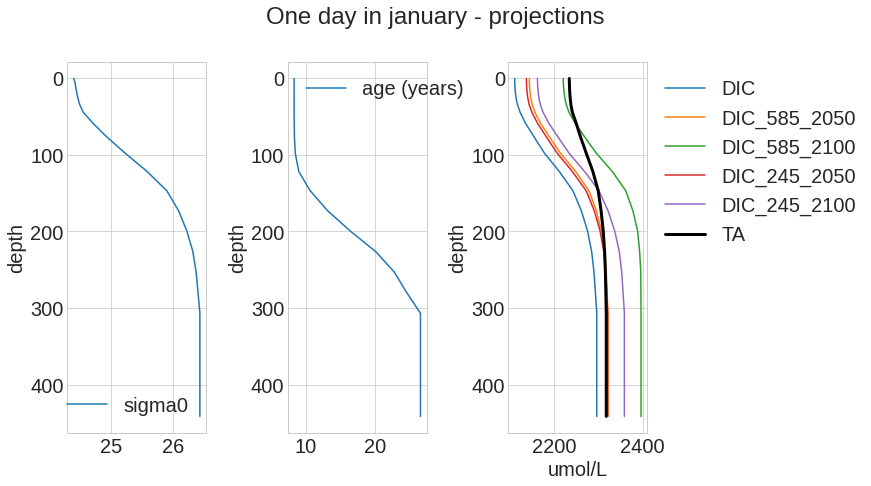

In [126]:
fact = 0.5
fig, axs = plt.subplots(1,3, figsize=(25*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
\

axs[0].plot(sigma0_dp,zlevels, label = 'sigma0')
axs[1].plot(age_dp,zlevels, label = 'age (years)')
axs[2].plot(DIC_dp,zlevels, label = 'DIC' )
axs[2].plot(DIC_585_2050,zlevels, label = 'DIC_585_2050' )
axs[2].plot(DIC_585_2100,zlevels, label = 'DIC_585_2100' )
axs[2].plot(DIC_245_2050,zlevels, label = 'DIC_245_2050' )
axs[2].plot(DIC_245_2100,zlevels, label = 'DIC_245_2100' )
#DIC_585_2050
axs[2].plot(TA_dp,zlevels, color = 'k', linewidth = 3, label = 'TA' )
axs[2].set_xlabel('umol/L')


for i in range(0,3):
    axs[i].invert_yaxis()
    axs[i].legend()
    axs[i].set_ylabel('depth')
    
axs[2].legend(bbox_to_anchor = [1,1])
plt.suptitle('One day in january - projections')
plt.tight_layout()

In [130]:
DIC_585_2100 - DIC_dp

masked_array(data=[109.37836118, 109.30260017, 109.48358713, 109.51541698,
                   109.53624882, 109.54910615, 109.5552016 , 109.54517924,
                   109.5559239 , 109.71937782, 109.71652819, 109.69573291,
                   109.6775678 , 109.82850762, 109.79149193, 109.76859513,
                   109.88087574, 109.84247098, 109.93933983, 110.00181673,
                   109.99691746, 110.09887487, 110.17684867, 110.32388523,
                   112.07929528, 114.15828119, 117.05384788, 119.57601035,
                   119.00984076, 116.42119658, 113.01487159, 108.26944122,
                   105.56357921, 102.63502361,  99.90202536,  99.90202536,
                    99.90202536,  99.90202536,  99.90202536,  99.90202536],
             mask=False,
       fill_value=1e+20)

In [121]:
pH, OmegaA_dp, pco2 =  oned_moxy(sal_dp, temp_dp, DIC_dp, TA_dp, 1, zlevels)

pH, OmegaA_245_2050, pco2 =  oned_moxy(sal_dp, temp_dp, DIC_245_2050, TA_dp, 1, zlevels)
pH, OmegaA_585_2050, pco2 =  oned_moxy(sal_dp, temp_dp, DIC_585_2050, TA_dp, 1, zlevels)

pH, OmegaA_245_2100, pco2 =  oned_moxy(sal_dp, temp_dp, DIC_245_2100, TA_dp, 1, zlevels)
pH, OmegaA_585_2100, pco2 =  oned_moxy(sal_dp, temp_dp, DIC_585_2100, TA_dp, 1, zlevels)

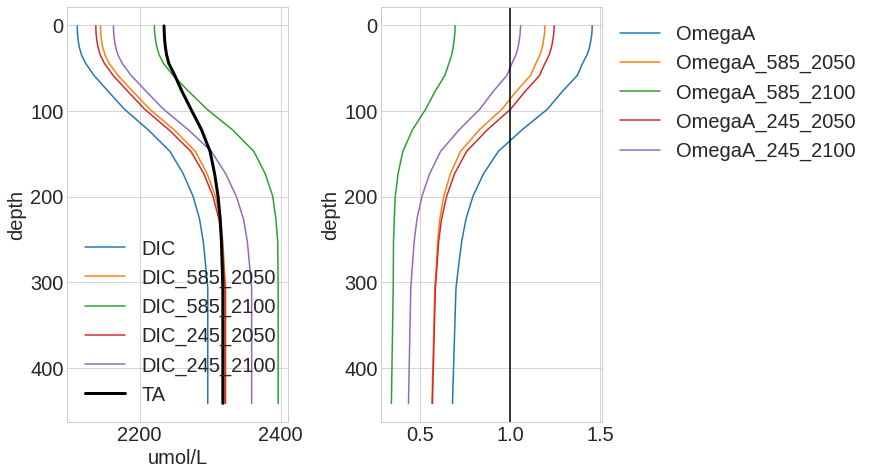

In [124]:
fact = 0.5
fig, axs = plt.subplots(1,2, figsize=(25*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(DIC_dp,zlevels, label = 'DIC' )
axs[0].plot(DIC_585_2050,zlevels, label = 'DIC_585_2050' )
axs[0].plot(DIC_585_2100,zlevels, label = 'DIC_585_2100' )
axs[0].plot(DIC_245_2050,zlevels, label = 'DIC_245_2050' )
axs[0].plot(DIC_245_2100,zlevels, label = 'DIC_245_2100' )

axs[1].plot(OmegaA_dp,zlevels, label = 'OmegaA' )
axs[1].plot(OmegaA_585_2050,zlevels, label = 'OmegaA_585_2050' )
axs[1].plot(OmegaA_585_2100,zlevels, label = 'OmegaA_585_2100' )
axs[1].plot(OmegaA_245_2050,zlevels, label = 'OmegaA_245_2050' )
axs[1].plot(OmegaA_245_2100,zlevels, label = 'OmegaA_245_2100' )
#DIC_585_2050
axs[0].plot(TA_dp,zlevels, color = 'k', linewidth = 3, label = 'TA' )
axs[0].set_xlabel('umol/L')
axs[1].axvline(x = 1, color = 'k')

for i in range(0,2):
    axs[i].invert_yaxis()
    axs[i].legend()
    axs[i].set_ylabel('depth')
    
axs[1].legend(bbox_to_anchor = [1,1])
plt.tight_layout()